# 🔍 Análise Exploratória de Dados (EDA) - Detecção de Fraudes

**Objetivo:** Este notebook documenta a investigação inicial sobre o dataset de transações de cartão de crédito. O objetivo aqui é entender a distribuição dos dados, identificar o nível de desbalanceamento das classes e embasar as decisões de Engenharia de Features (Feature Engineering) que serão aplicadas no pipeline final (`src/preprocessing.py`).

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações visuais
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [14]:
# Carregar o dataset
data_path = '../data/train.csv'

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")
else:
    print("Arquivo não encontrado. Verifique o caminho.")

Dataset carregado com 227845 linhas e 32 colunas.


## 1. O Problema do Desbalanceamento
O principal desafio em datasets de detecção de fraudes é o desbalanceamento extremo. Vamos verificar a proporção exata entre transações legítimas e fraudulentas para definir a estratégia de modelagem (ex: uso de `scale_pos_weight` ou `is_unbalance=True` nos algoritmos).

Normal: 227451 (99.83%)
Fraude: 394 (0.17%)


C:\Users\sirmi\AppData\Local\Temp\ipykernel_24844\2524009959.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort=True)


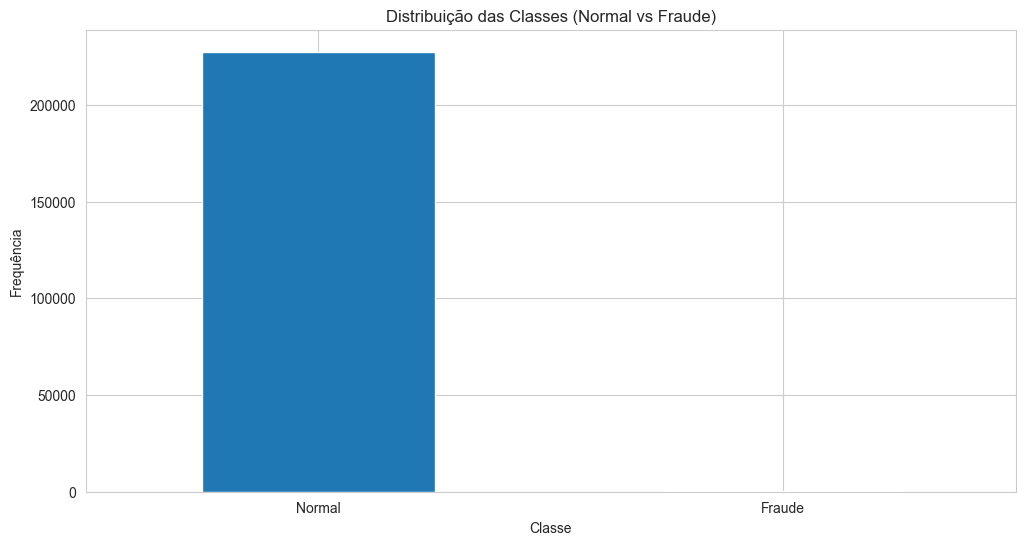

In [15]:
count_classes = pd.value_counts(df['Class'], sort=True)
print(f"Normal: {count_classes[0]} ({count_classes[0]/len(df)*100:.2f}%)")
print(f"Fraude: {count_classes[1]} ({count_classes[1]/len(df)*100:.2f}%)")

count_classes.plot(kind='bar', rot=0, color=['#1f77b4', '#d62728'])
plt.title("Distribuição das Classes (Normal vs Fraude)")
plt.xticks(range(2), ['Normal', 'Fraude'])
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.show()

## 2. Análise Temporal (Feature 'Time')
A variável `Time` original contém os segundos decorridos desde a primeira transação. Transações fraudulentas costumam ter padrões de horários diferentes (ex: madrugadas). Vamos analisar se há diferença visual na distribuição para justificar a conversão de segundos para "hora do dia" no nosso pré-processamento.

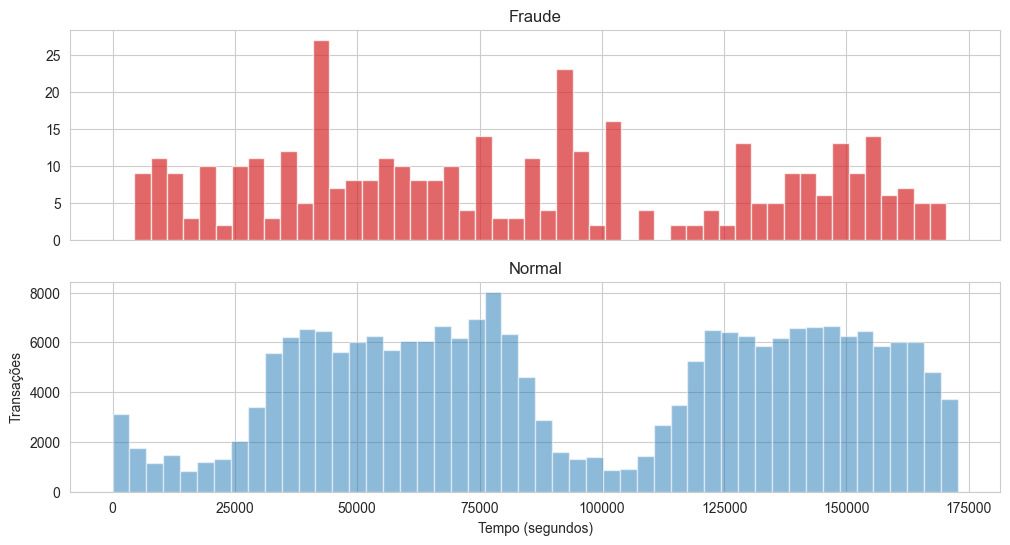

Observa-se variação temporal nas fraudes ao longo do período observado, indicando possível comportamento sequencial.


In [16]:
# Verificar se as fraudes acontecem em horários específicos
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

ax1.hist(df.Time[df.Class == 1], bins=50, color='#d62728', alpha=0.7)
ax1.set_title('Fraude')

ax2.hist(df.Time[df.Class == 0], bins=50, color='#1f77b4', alpha=0.5)
ax2.set_title('Normal')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.show()

print("Observa-se variação temporal nas fraudes ao longo do período observado, indicando possível comportamento sequencial.")

## 3. Análise Monetária (Feature 'Amount')
O valor da transação (`Amount`) pode conter outliers extremos, o que prejudica algoritmos baseados em árvores se não for bem tratado. Vamos visualizar sua distribuição em escala logarítmica para decidir a melhor técnica de escalonamento (optaremos pelo `RobustScaler` devido à resistência a outliers).

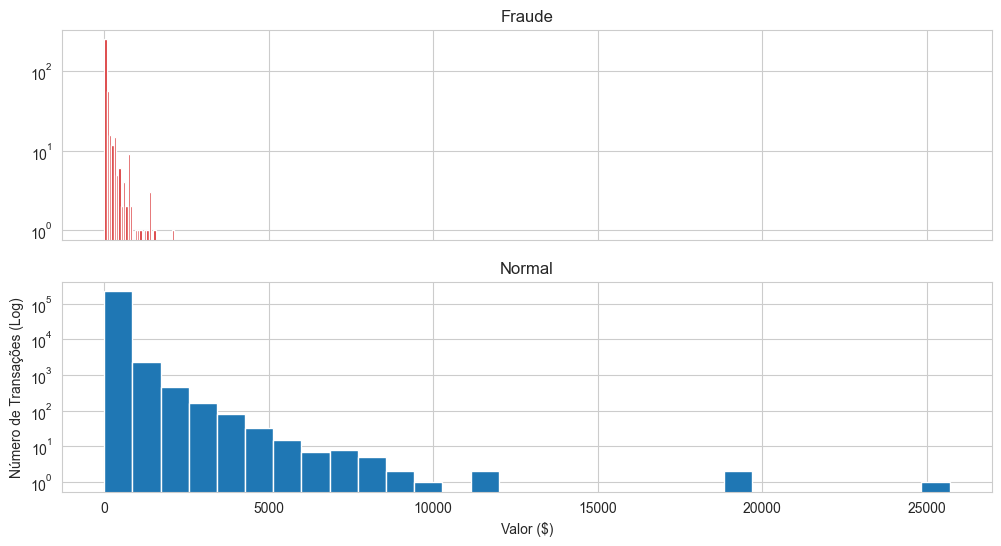

Fraudes tendem a ser de valores menores, mas existem outliers. Isso justifica o uso do RobustScaler.


In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Usar escala logarítmica para melhor visualização dos valores
ax1.hist(df.Amount[df.Class == 1], bins=30, color='#d62728')
ax1.set_title('Fraude')
ax1.set_yscale('log')

ax2.hist(df.Amount[df.Class == 0], bins=30, color='#1f77b4')
ax2.set_title('Normal')
ax2.set_yscale('log')

plt.xlabel('Valor ($)')
plt.ylabel('Número de Transações (Log)')
plt.show()

print("Fraudes tendem a ser de valores menores, mas existem outliers. Isso justifica o uso do RobustScaler.")

## 4. Correlação Linear com o Target
Antes de aplicar modelos complexos e explicabilidade com SHAP, vamos verificar quais variáveis anonimizadas (V1 a V28) possuem maior correlação linear (positiva ou negativa) com a ocorrência de fraudes. Isso nos dará uma linha de base sobre o poder preditivo do dataset.

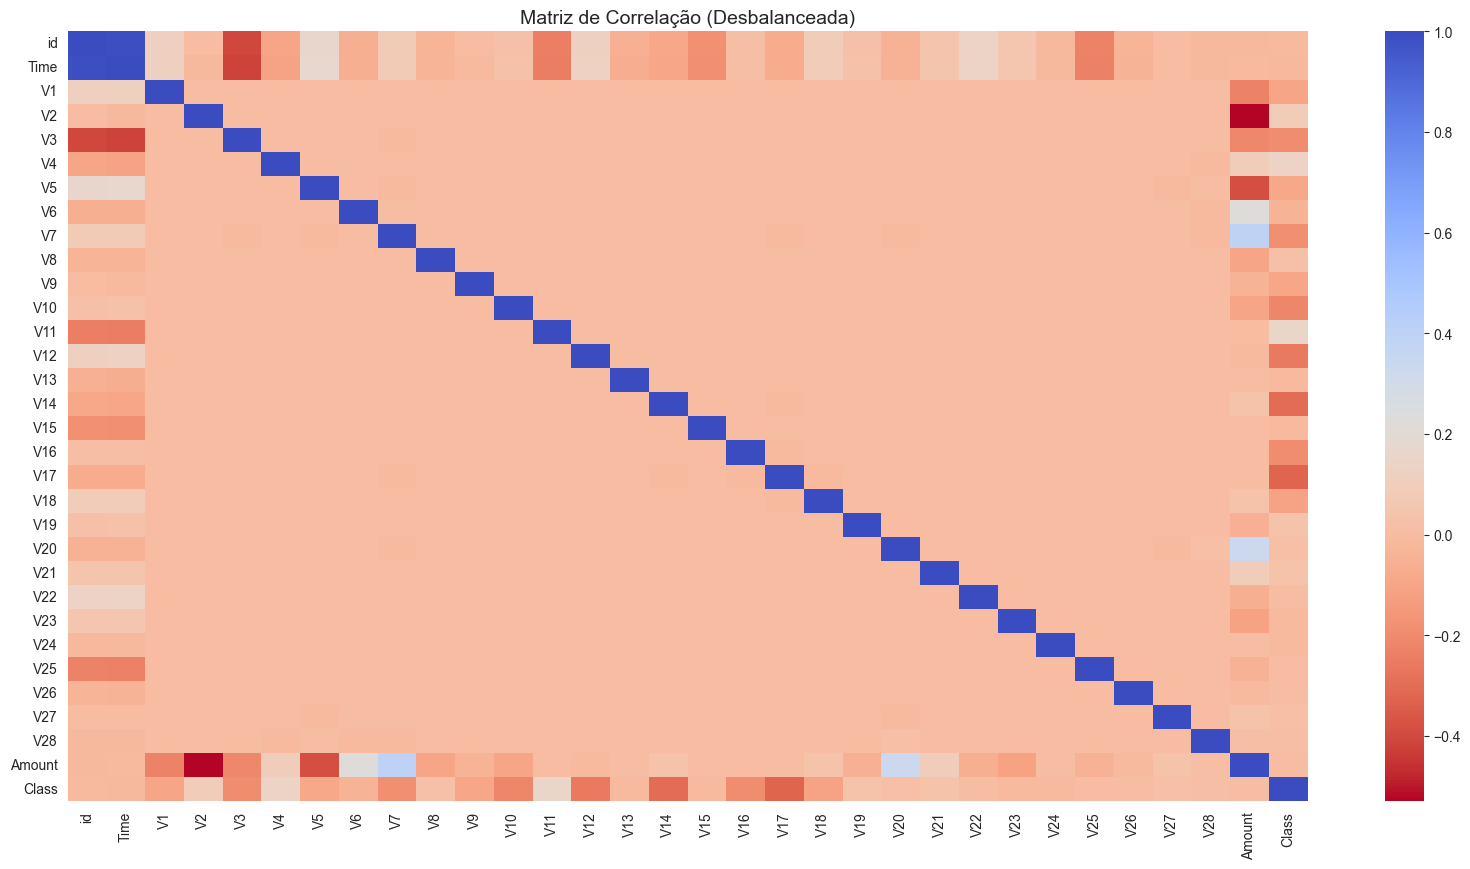

Top Correlações Positivas:
 Class    1.000000
V11      0.153709
V4       0.135014
V2       0.090586
V21      0.035588
dtype: float64

Top Correlações Negativas (Quanto menor, maior risco):
 V3    -0.194135
V10   -0.217894
V12   -0.259989
V14   -0.301054
V17   -0.321937
dtype: float64


In [18]:
# Matriz de correlação
plt.figure(figsize=(20, 10))
# Usar cmap 'coolwarm_r' para destacar correlações negativas (em vermelho) e positivas (em azul)
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.title("Matriz de Correlação (Desbalanceada)", fontsize=14)
plt.show()

# Focando nas correlações com a Classe
corr_target = df.corrwith(df['Class']).sort_values(ascending=False)
print("Top Correlações Positivas:\n", corr_target.head(5))
print("\nTop Correlações Negativas (Quanto menor, maior risco):\n", corr_target.tail(5))

## 📌 Conclusão da EDA e Decisões de Arquitetura
Com base nesta exploração, foi definido as seguintes regras para o pipeline de produção:
1. **Desbalanceamento (0.17%):** Não será usado SMOTE para evitar dados sintéticos ruidosos; trataremos o peso das classes nativamente nos hiperparâmetros do LightGBM e XGBoost.
2. **Feature Temporal:** Criaremos a feature `Hour` a partir da variável `Time`.
3. **Escalonamento:** Usaremos `RobustScaler` na variável `Amount` para mitigar o peso de transações atipicamente altas.

*Estas etapas estão codificadas e automatizadas no arquivo `src/preprocessing.py`.*